# Blackbird Dataset
## Description
Initial investigation into [MIT's Blackbird Dataset](http://blackbird-dataset.mit.edu/BlackbirdDatasetData/dice/yawForward/maxSpeed1p0/csv/?prefix=BlackbirdDatasetData/) which involves a quadcopter flying in a flight cage. This dataset has both a [paper](https://arxiv.org/abs/1810.01987) and [Github](https://github.com/mit-fast/Blackbird-Dataset) associated with it.

## Data Exploration

Using the Pandas library, a singular flight data set will be downloaded into a pandas dataframe using a url. Due to the size of the datasets, csv files will be looked at individually. Ordering is:

1. State - Vicon system
        * Global position
        * Rotation angles (Quaternians)
2. IMU - Xsens MTi-3 IMU

### Vicon System

In [14]:
import pandas as pd
import io
import requests

urlhead = "http://blackbird-dataset.mit.edu/BlackbirdDatasetData/" + \
          "figure8/" + \
          "yawConstant/" +\
          "maxSpeed0p5/csv/"

url = urlhead + "blackbird_slash_state.csv"
contents = requests.get(url).content
pos_and_orien = pd.read_csv(io.StringIO(contents.decode('utf-8')))
pos_and_orien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 17 columns):
rosbagTimestamp    77287 non-null int64
header             0 non-null float64
seq                77287 non-null int64
stamp              0 non-null float64
secs               77287 non-null int64
nsecs              77287 non-null int64
frame_id           77287 non-null object
pose               0 non-null float64
position           0 non-null float64
x                  77287 non-null float64
y                  77287 non-null float64
z                  77287 non-null float64
orientation        0 non-null float64
x.1                77287 non-null float64
y.1                77287 non-null float64
z.1                77287 non-null float64
w                  77287 non-null float64
dtypes: float64(12), int64(4), object(1)
memory usage: 10.0+ MB


In [15]:
pos_and_orien.head()

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,position,x,y,z,orientation,x.1,y.1,z.1,w
0,1526617312016142000,NaN,1,NaN,1526617312,16142000,"""mocap""",NaN,NaN,-3.393845,0.261713,-0.926976,NaN,-0.008990,0.024020,-0.031950,0.999160
1,1526617312018921000,NaN,4,NaN,1526617312,18921000,"""mocap""",NaN,NaN,-3.393903,0.261800,-0.926810,NaN,-0.008838,0.024517,-0.031534,0.999163
2,1526617312021699000,NaN,6,NaN,1526617312,21699000,"""mocap""",NaN,NaN,-3.393929,0.261766,-0.927067,NaN,-0.009055,0.023970,-0.031980,0.999160
3,1526617312024477000,NaN,8,NaN,1526617312,24477000,"""mocap""",NaN,NaN,-3.393887,0.261701,-0.926861,NaN,-0.008776,0.023786,-0.031966,0.999167
4,1526617312027254000,NaN,11,NaN,1526617312,27254000,"""mocap""",NaN,NaN,-3.393841,0.261676,-0.926848,NaN,-0.008549,0.024100,-0.031734,0.999169


In [2]:
#Adjustments
#Adjust timescale
sec_start_ref = pos_and_orien.at[1,'secs']
nsec_start_ref = pos_and_orien.at[1,'nsecs']

pos_and_orien['secs'] = pos_and_orien['secs'] - sec_start_ref
pos_and_orien['nsecs'] = pos_and_orien['nsecs'] - nsec_start_ref

# Drop empty columns
pos_and_orien = pos_and_orien.drop(['header',\
                                    'stamp',\
                                    'pose',\
                                    'position',\
                                    'orientation'],\
                                    axis=1)
#Rename variables and add units
pos_and_orien = pos_and_orien.rename(columns={"x" : "px_[m]",\
                                              "y" : "py_[m]",\
                                              "z" : "pz_[m]",\
                                              "x.1" : "qx",\
                                              "y.1" : "qy",\
                                              "z.1" : "qz",\
                                              "w" : "qw"})

pos_and_orien.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 12 columns):
rosbagTimestamp    77287 non-null int64
seq                77287 non-null int64
secs               77287 non-null int64
nsecs              77287 non-null int64
frame_id           77287 non-null object
px_[m]             77287 non-null float64
py_[m]             77287 non-null float64
pz_[m]             77287 non-null float64
qx                 77287 non-null float64
qy                 77287 non-null float64
qz                 77287 non-null float64
qw                 77287 non-null float64
dtypes: float64(7), int64(4), object(1)
memory usage: 7.1+ MB


In [3]:
import math

# Transform quaternions into Euler angles
for i in range(pos_and_orien.index[-1]):
    q0 = pos_and_orien.at[i, 'qw']
    q1 = pos_and_orien.at[i, 'qx']
    q2 = pos_and_orien.at[i, 'qy']
    q3 = pos_and_orien.at[i, 'qz']
    pos_and_orien.at[i,'roll_[rad]'] = math.atan2(2*(q0*q1 + q2*q3),\
                                                  q0*q0 + q3*q3 - q1*q1 - q2*q2)
    pos_and_orien.at[i,'pitch_[rad]'] = math.asin(2*(q0*q2 - q3*q1))
    pos_and_orien.at[i,'yaw_[rad]'] = math.atan2(2*(q0*q3 + q1*q2),\
                                                  q0*q0 + q1*q1 - q3*q3 - q2*q2)

<IPython.core.display.Javascript object>


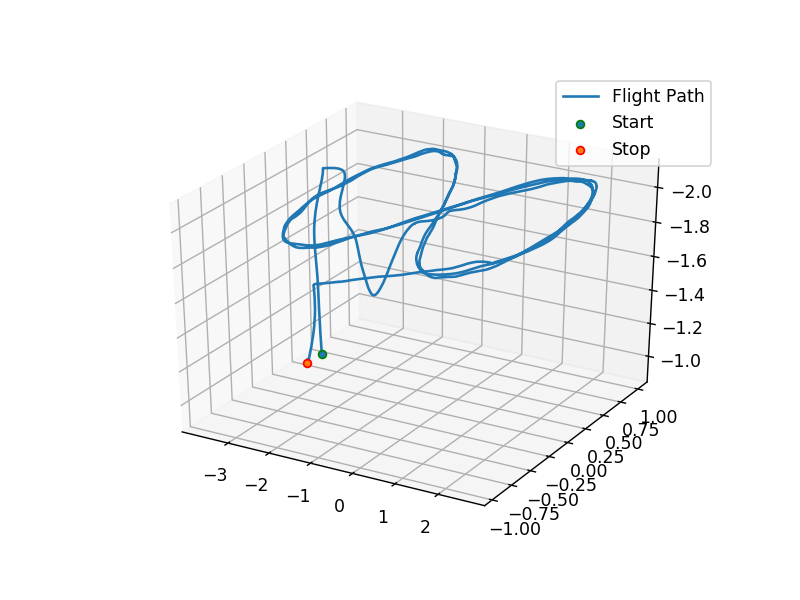

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.invert_zaxis()

Npao = pos_and_orien.index[-1]

ax.plot(pos_and_orien['px_[m]'],\
        pos_and_orien['py_[m]'],\
        pos_and_orien['pz_[m]'],\
        label="Flight Path")
ax.scatter(pos_and_orien.at[1,'px_[m]'],\
           pos_and_orien.at[1,'py_[m]'],\
           pos_and_orien.at[1,'pz_[m]'],\
           marker="o", edgecolor = "g", label="Start")
ax.scatter(pos_and_orien.at[Npao,'px_[m]'],\
           pos_and_orien.at[Npao,'py_[m]'],\
           pos_and_orien.at[Npao,'pz_[m]'],\
           marker="o", edgecolor = "r", label="Stop")
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


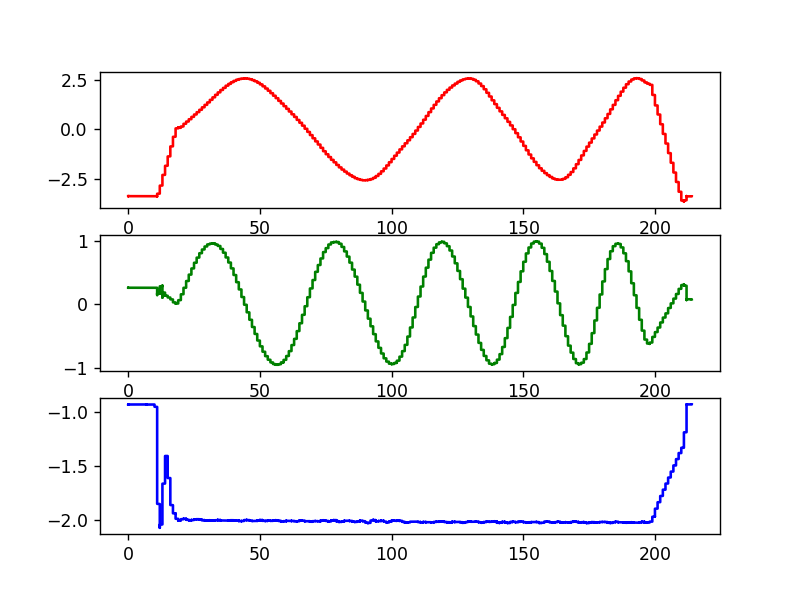

In [5]:
fig,ax = plt.subplots(3,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['px_[m]'], color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['py_[m]'], color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['pz_[m]'], color='b')

plt.show()

<IPython.core.display.Javascript object>


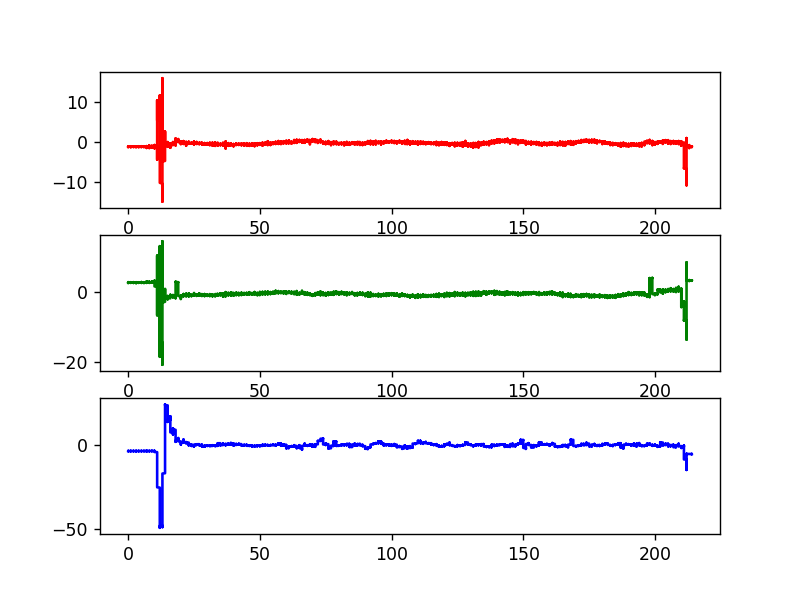

<function matplotlib.pyplot.show(*args, **kw)>

In [6]:
import math

fig,ax = plt.subplots(3,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['roll_[rad]'].apply(math.degrees), color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['pitch_[rad]'].apply(math.degrees), color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['yaw_[rad]'].apply(math.degrees), color='b')

plt.show

In [7]:
pos_and_orien['|deltax|'] = pos_and_orien['px_[m]'].diff().apply(math.fabs)
pos_and_orien['|deltay|'] = pos_and_orien['py_[m]'].diff().apply(math.fabs)
pos_and_orien['|deltaz|'] = pos_and_orien['pz_[m]'].diff().apply(math.fabs)

<IPython.core.display.Javascript object>


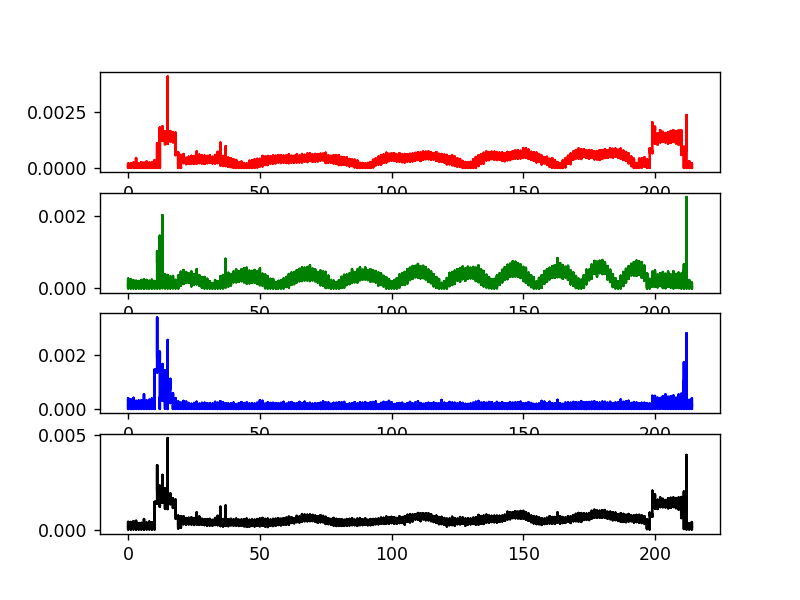

In [8]:
import numpy as np

fig,ax = plt.subplots(4,1)

ax[0].plot(pos_and_orien['secs'], pos_and_orien['|deltax|'], color='r')
ax[1].plot(pos_and_orien['secs'], pos_and_orien['|deltay|'], color='g')
ax[2].plot(pos_and_orien['secs'], pos_and_orien['|deltaz|'], color='b')
ax[3].plot(pos_and_orien['secs'], (pos_and_orien['|deltax|'].apply(np.square) +\
                                   pos_and_orien['|deltay|'].apply(np.square) +\
                                   pos_and_orien['|deltaz|'].apply(np.square)).apply(np.sqrt),\
           color='k')

plt.show()

### IMU

In [12]:
url = urlhead + "blackbird_slash_imu.csv"
contents = requests.get(url).content
imu_df = pd.read_csv(io.StringIO(contents.decode('utf-8')))
imu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21298 entries, 0 to 21297
Data columns (total 23 columns):
rosbagTimestamp                   21298 non-null int64
header                            0 non-null float64
seq                               21298 non-null int64
stamp                             0 non-null float64
secs                              21298 non-null int64
nsecs                             21298 non-null int64
frame_id                          21298 non-null object
orientation                       0 non-null float64
x                                 21298 non-null float64
y                                 21298 non-null float64
z                                 21298 non-null float64
w                                 21298 non-null float64
orientation_covariance            21298 non-null object
angular_velocity                  0 non-null float64
x.1                               21298 non-null float64
y.1                               21298 non-null float64
z.1  

In [10]:
#Adjustments
#Adjust timescale
imu_df['secs'] = imu_df['secs'] - sec_start_ref
imu_df['nsecs'] = imu_df['nsecs'] - nsec_start_ref

# Drop empty columns
imu_df = imu_df.drop(['header',\
                      'stamp',\
                      'orientation',\
                      'angular_velocity',\
                      'linear_acceleration'],\
                     axis=1)
#Rename variables and add units
imu_df = imu_df.rename(columns={"x" : "qx",\
                                "y" : "qy",\
                                "z" : "qz",\
                                "w" : "qw",\
                                "x.1" : "omegax_[rps]",\
                                "y.1" : "omegay_[rps]",\
                                "z.1" : "omegaz_[rps]",\
                                "x.2" : "ax_[m/s2]",\
                                "y.2" : "ay_[m/s2]",\
                                "z.2" : "az_[m/s2]"})

imu_df.head()

,rosbagTimestamp,seq,secs,nsecs,frame_id,qx,qy,qz,qw,orientation_covariance,omegax_[rps],omegay_[rps],omegaz_[rps],angular_velocity_covariance,ax_[m/s2],ay_[m/s2],az_[m/s2],linear_acceleration_covariance
0,1526617313775493000,1,1,756572000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.008281,0.000012,-0.004600,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.053711,-0.392242,-9.741584,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
1,1526617313785488000,2,1,766567000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007907,0.001821,-0.004601,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.053214,-0.393957,-9.768647,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
2,1526617313795714000,3,1,776793000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007325,0.001418,-0.004686,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.056948,-0.403248,-9.744291,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
3,1526617313805476000,4,1,786555000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.006052,-0.000305,-0.003774,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.074306,-0.393690,-9.778463,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
4,1526617313815443000,5,1,796522000,"""imu""",0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",-0.007407,0.001025,-0.005490,"[0.0001, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0, 0.0,...",0.067153,-0.394343,-9.781151,"[0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.01]"
